Movielens 영화 SBR
=======

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

- Movielens 1M Dataset     
    https://www.kaggle.com/odedgolden/movielens-1m-dataset
- Session based Recommendation    
    세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천을 말합니다.
    
-21.11.11-

In [1]:
# 데이터 확인
!ls -l ~/aiffel/Exploration/E12/data

total 4
lrwxrwxrwx 1 root root   31 Nov  4 01:35 dataset-README.txt -> /aiffel/data/dataset-README.txt
lrwxrwxrwx 1 root root   23 Nov  4 01:35 movies.dat -> /aiffel/data/movies.dat
drwxr-xr-x 3 root root 4096 Nov 10 16:21 processed
lrwxrwxrwx 1 root root   24 Nov  4 01:35 ratings.dat -> /aiffel/data/ratings.dat
lrwxrwxrwx 1 root root   19 Nov  4 01:35 README -> /aiffel/data/README
lrwxrwxrwx 1 root root   22 Nov  4 01:35 users.dat -> /aiffel/data/users.dat
lrwxrwxrwx 1 root root   31 Nov  4 01:35 yoochoose-buys.dat -> /aiffel/data/yoochoose-buys.dat
lrwxrwxrwx 1 root root   33 Nov  4 01:35 yoochoose-clicks.dat -> /aiffel/data/yoochoose-clicks.dat
lrwxrwxrwx 1 root root   31 Nov  4 01:35 yoochoose-test.dat -> /aiffel/data/yoochoose-test.dat


In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 데이터 설명(README)를 읽어 봅니다. 
f = open(os.getenv('HOME')+'/aiffel/Exploration/E12/data/README', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

# 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.    
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

## 1.1 Data Load

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/Exploration/E12/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 입니다.

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

유저의 숫자가 약 6천 개, 아이템 숫자는 약 3천 7백 개가 됩니다.

Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있음으로 보기 편한 시간으로 변환해 줍니다. 

- 유닉스 시간(영어: Unix time) : 1970년 1월 1일 00:00:00 협정 세계시(UTC) 부터의 경과 시간을 초로 환산하여 정수로 나타낸 것이다

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [7]:
import time

def utctime(intime):
    #local_time = utc_time.replace(tzinfo=pytz.utc).astimezone(local_timezone)
    #print(time.strftime('%Y-%m-%d %H', time.localtime(intime)))
    return time.strftime('%Y-%m-%d %H:%M:%S.%s', time.localtime(intime))

print(utctime(data['Time'][0]))

2000-12-31 22:12:40.978300760


- time.strftime()    
    https://www.daleseo.com/python-time/

In [8]:
data['Time'] = data['Time'].apply(utctime)
    
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19.978300019
22,1,1270,5,2000-12-31 22:00:55.978300055
27,1,1721,4,2000-12-31 22:00:55.978300055
37,1,1022,5,2000-12-31 22:00:55.978300055
24,1,2340,3,2000-12-31 22:01:43.978300103


## 1.2 Session Length

각 세션(UserId)이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보겠습니다.    

일단 한 세션을 어떻게 할지 userID 하나의 데이터를 확인해 보겠습니다. 

In [9]:
data[data['UserId']==8]

,UserId,ItemId,Rating,Time
631,8,1210,4,2000-12-31 02:13:09.978228789
646,8,111,5,2000-12-31 02:13:52.978228832
641,8,908,5,2000-12-31 02:14:42.978228882
670,8,3481,4,2000-12-31 02:14:42.978228882
629,8,1573,4,2000-12-31 02:16:00.978228960
...,...,...,...,...
565,8,3213,3,2000-12-31 03:31:02.978233462
609,8,1274,5,2000-12-31 03:31:02.978233462
581,8,1,4,2000-12-31 03:31:36.978233496
610,8,741,5,2000-12-31 03:32:06.978233526


- 보통 같은 날짜에 연속 시간이 많기는 하지만 몇시간 간격으로 떨어진 데이터도 있기 때문에 년,월,일,시 까지만 같은 세션으로 하겠습니다. 

In [10]:
data['setime'] = data['Time'].apply(lambda x : x[:13])
    
data

,UserId,ItemId,Rating,Time,setime
31,1,3186,4,2000-12-31 22:00:19.978300019,2000-12-31 22
22,1,1270,5,2000-12-31 22:00:55.978300055,2000-12-31 22
27,1,1721,4,2000-12-31 22:00:55.978300055,2000-12-31 22
37,1,1022,5,2000-12-31 22:00:55.978300055,2000-12-31 22
24,1,2340,3,2000-12-31 22:01:43.978300103,2000-12-31 22
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29.997454429,2001-08-10 14
999988,6040,1921,4,2001-08-10 14:41:04.997454464,2001-08-10 14
1000172,6040,1784,3,2001-08-10 14:41:04.997454464,2001-08-10 14
1000167,6040,161,3,2001-08-10 14:41:26.997454486,2001-08-10 14


In [11]:
global ind
ind = 0
def set_index(x):
    global ind
    ind += 1
    return ind

data['SessionId'] = data.groupby(['UserId', 'setime'])['UserId'].transform(set_index)
data

,UserId,ItemId,Rating,Time,setime,SessionId
31,1,3186,4,2000-12-31 22:00:19.978300019,2000-12-31 22,1
22,1,1270,5,2000-12-31 22:00:55.978300055,2000-12-31 22,1
27,1,1721,4,2000-12-31 22:00:55.978300055,2000-12-31 22,1
37,1,1022,5,2000-12-31 22:00:55.978300055,2000-12-31 22,1
24,1,2340,3,2000-12-31 22:01:43.978300103,2000-12-31 22,1
...,...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29.997454429,2001-08-10 14,31968
999988,6040,1921,4,2001-08-10 14:41:04.997454464,2001-08-10 14,31968
1000172,6040,1784,3,2001-08-10 14:41:04.997454464,2001-08-10 14,31968
1000167,6040,161,3,2001-08-10 14:41:26.997454486,2001-08-10 14,31968


- SessionId 컬럼을 새로 지정해 줍니다. 
- groupby 결과를 컬럼에 적용 :     
    https://leedakyeong.tistory.com/entry/Python-Pandas-Tutorial-groupby-transform-groupby-%EA%B2%B0%EA%B3%BC-%EC%BB%AC%EB%9F%BC%EC%97%90-%EC%B6%94%EA%B0%80%ED%95%98%EA%B8%B0

In [12]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         40
2         13
3        109
4         20
5         51
        ... 
31965     13
31966      1
31967      1
31968     21
31969      1
Length: 31969, dtype: int64

- 여기서 session_length란 같은 UserId를 공유하며 시간중 년,월,일,시가 같은(SessionId가 같은) 데이터 row의 개수를 의미합니다.     
    따라서 여기서 session_length란 해당 시간의 사용자가 그 시간(1) 동안 몇번의 액션을 취했는지(몇개의 상품정보를 클릭했는지)의 의미가 됩니다.

In [13]:
session_length.median(), session_length.mean()

(8.0, 31.286840376614844)

In [14]:
session_length.min(), session_length.max()

(1, 711)

In [15]:
session_length.quantile(0.99)

242.0

길이가 711인 세션은 뭔가 이상합니다. 하나를 잡고 살펴봅시다.

In [16]:
long_session = session_length[session_length==711].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,setime,SessionId
137631,889,1266,3,2000-11-26 14:11:02.975247862,2000-11-26 14,4607
137864,889,2430,3,2000-11-26 14:11:02.975247862,2000-11-26 14,4607
137889,889,1643,3,2000-11-26 14:11:02.975247862,2000-11-26 14,4607
138039,889,3461,3,2000-11-26 14:11:02.975247862,2000-11-26 14,4607
138316,889,1193,1,2000-11-26 14:11:02.975247862,2000-11-26 14,4607
...,...,...,...,...,...,...
139066,889,3785,2,2000-11-26 14:59:23.975250763,2000-11-26 14,4607
137640,889,597,4,2000-11-26 14:59:35.975250775,2000-11-26 14,4607
137878,889,3099,4,2000-11-26 14:59:35.975250775,2000-11-26 14,4607
137831,889,2424,3,2000-11-26 14:59:47.975250787,2000-11-26 14,4607


- 매우 짧은 간격으로 지속적으로 클릭을 1시간 동안 지속하고 있습니다.

세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다.
아래는 세션길이 기준 하위 99%까지의 분포 누적합을 시각화한 것입니다.

In [17]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_99

1      0.237480
2      0.329663
3      0.378742
4      0.413056
5      0.445400
         ...   
237    0.989271
238    0.989396
239    0.989521
240    0.989740
241    0.989896
Length: 241, dtype: float64

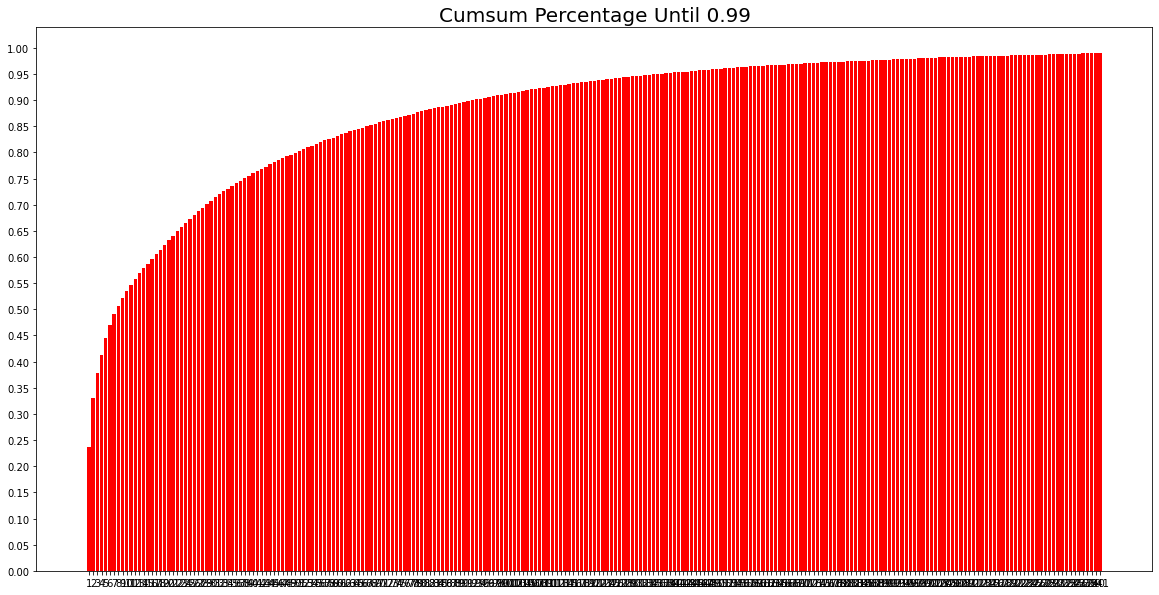

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

## 1.3 Session Time

추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 이번에는 데이터가 발생한 시간에 대해 알아봅시다.

In [19]:
type(data['Time'][0])

str

In [20]:
from datetime import datetime
import time

data['Time'] = data['Time'].apply(lambda x : pd.to_datetime(x))

- datetime 타입으로 바꿔줍니다.  
- pd.to_datetime()    
    https://cosmosproject.tistory.com/23

In [21]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32.956703932
2003-02-28 17:49:50.104645459


3년 정도의 데이터가 있습니다. 이 중 1년치 데이터만 사용하려고 합니다. 

In [22]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

- latest는 Timestamp 객체로 바꾸었기 때문에 int 객체와의 사칙연산을 지원하지 않습니다.   
    날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용합니다.

In [23]:
month_ago = latest - dt.timedelta(365)  # 최종 날짜로부터 365일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data.sort_values(['Time', 'SessionId'])

,UserId,ItemId,Rating,Time,setime,SessionId
348285,2041,1213,4,2002-02-28 19:06:39.101492319,2002-02-28 19,12272
348057,2041,2300,4,2002-02-28 19:07:22.101492324,2002-02-28 19,12272
347973,2041,2692,5,2002-02-28 19:08:34.101492331,2002-02-28 19,12272
347787,2041,2208,5,2002-02-28 19:11:39.101492349,2002-02-28 19,12272
348165,2041,1923,3,2002-02-28 19:14:41.101492368,2002-02-28 19,12272
...,...,...,...,...,...,...
825793,4958,2399,1,2003-02-28 17:45:38.104645433,2003-02-28 17,26396
825438,4958,1407,5,2003-02-28 17:47:23.104645444,2003-02-28 17,26396
825724,4958,3264,4,2003-02-28 17:49:08.104645454,2003-02-28 17,26396
825731,4958,2634,3,2003-02-28 17:49:08.104645454,2003-02-28 17,26396


## 1.4 Data Cleansing

- 1.2에서 살펴보니 길이가 1인 세션도 꽤 있습니다. 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해줍니다.         
- 너무 적게(5미만) 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해줍니다.       
- 평가가 3미만으로 된 아이템 또한 추천해 줄 필요가 없기 때문에 제거해줍니다. 

In [24]:
# short_session을 제거한 다음 unpopular item, lowest rating을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click, lowest_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        data = cleanse_lowest_rating(data, lowest_rating)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby(['SessionId']).size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

def cleanse_lowest_rating(data: pd.DataFrame, lowest_rating):
    data = data[data['Rating'] >= lowest_rating]
    return data

In [25]:
data = cleanse_recursive(data, shortest=2, least_click=5, lowest_rating=3)
data.sort_values(['SessionId', 'Time']).head(20)

,UserId,ItemId,Rating,Time,setime,SessionId
5170,36,1387,5,2002-03-12 03:46:59.101590481,2002-03-12 03,118
5267,36,1201,4,2002-03-12 03:46:59.101590481,2002-03-12 03,118
5122,36,1291,5,2002-03-12 03:47:16.101590483,2002-03-12 03,118
5123,36,2167,5,2002-03-12 03:48:25.101590490,2002-03-12 03,118
5290,36,2951,4,2002-03-12 03:48:25.101590490,2002-03-12 03,118
5359,36,2115,5,2002-03-12 03:48:25.101590490,2002-03-12 03,118
5073,36,1912,5,2002-03-12 03:48:44.101590492,2002-03-12 03,118
5113,36,2662,3,2002-03-12 03:48:44.101590492,2002-03-12 03,118
5366,36,2985,4,2002-03-12 03:49:01.101590494,2002-03-12 03,118
5145,36,198,5,2002-03-12 03:49:48.101590498,2002-03-12 03,118


In [26]:
data.groupby(['SessionId']).size().min(), data.groupby('ItemId').size().min(), data['Rating'].min()

(2, 5, 3)

이것으로 데이터 전처리가 모두 끝났습니다.    
필요 없는 컬럼은 삭제해줍니다. 

In [27]:
data.drop(['setime'], axis=1, inplace=True)
data.sort_values(['Time', 'SessionId'], inplace=True)
data

,UserId,ItemId,Rating,Time,SessionId
348285,2041,1213,4,2002-02-28 19:06:39.101492319,12272
348057,2041,2300,4,2002-02-28 19:07:22.101492324,12272
347973,2041,2692,5,2002-02-28 19:08:34.101492331,12272
347787,2041,2208,5,2002-02-28 19:11:39.101492349,12272
348165,2041,1923,3,2002-02-28 19:14:41.101492368,12272
...,...,...,...,...,...
984475,5950,3793,3,2003-02-27 18:15:10.104636971,31591
984733,5950,1262,4,2003-02-27 18:17:38.104636985,31591
825526,4958,3489,4,2003-02-28 17:45:20.104645432,26396
825438,4958,1407,5,2003-02-28 17:47:23.104645444,26396


## 1.5 Train/ Valid/ Test split

모델 평가를 위해 Valid Set과 Test Set을 만들어 봅니다.    

Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다.      
이번 자료에서는 가장 마지막 15일 기간 동안을 Test로, 15일전부터 30일전 까지를 valid set으로 나누겠습니다.

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [29]:
tr, test = split_by_date(data, n_days=15)
tr, val = split_by_date(tr, n_days=15)

In [30]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 11413
	 Sessions: 1259
	 Items: 1129
	 First Time : 2002-02-28 19:06:39.101492319
	 Last Time : 2003-01-26 18:49:43.104360698

* valid Set Stats Info
	 Events: 680
	 Sessions: 44
	 Items: 513
	 First Time : 2003-01-28 18:41:15.104377927
	 Last Time : 2003-02-11 22:59:20.104500436

* test Set Stats Info
	 Events: 397
	 Sessions: 48
	 Items: 325
	 First Time : 2003-02-13 18:06:30.104515959
	 Last Time : 2003-02-28 17:49:08.104645454



In [32]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

# 2. Data Pipeline

GRU4REC 논문을 바탕으로 Session-Parallel Mini-Batch 를 구현해 봅니다.

- GRU4REC : 
    chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Farxiv.org%2Fpdf%2F1511.06939v4.pdf&clen=311412&chunk=true

## 2.1 SessionDataset

데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.

- click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
- session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.

In [34]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
348285,2041,1213,4,2002-02-28 19:06:39.101492319,12272,0
348057,2041,2300,4,2002-02-28 19:07:22.101492324,12272,1
347973,2041,2692,5,2002-02-28 19:08:34.101492331,12272,2
347787,2041,2208,5,2002-02-28 19:11:39.101492349,12272,3
348165,2041,1923,3,2002-02-28 19:14:41.101492368,12272,4
348069,2041,1517,3,2002-02-28 19:16:54.101492381,12272,5
347778,2041,728,3,2002-02-28 19:18:21.101492390,12272,6
348125,2041,1732,4,2002-02-28 19:21:39.101492409,12272,7
348241,2041,43,3,2002-02-28 19:23:21.101492420,12272,8
348063,2041,1366,4,2002-02-28 19:25:39.101492433,12272,9


In [35]:
tr_dataset.click_offsets

array([    0,    13,    25, ..., 11373, 11397, 11413], dtype=int32)

In [36]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 1256, 1257, 1258])

## 2.2 SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
- \__iter\__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
- mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [37]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [38]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
348285,2041,1213,4,2002-02-28 19:06:39.101492319,12272,0
348057,2041,2300,4,2002-02-28 19:07:22.101492324,12272,1
347973,2041,2692,5,2002-02-28 19:08:34.101492331,12272,2
347787,2041,2208,5,2002-02-28 19:11:39.101492349,12272,3
348165,2041,1923,3,2002-02-28 19:14:41.101492368,12272,4
348069,2041,1517,3,2002-02-28 19:16:54.101492381,12272,5
347778,2041,728,3,2002-02-28 19:18:21.101492390,12272,6
348125,2041,1732,4,2002-02-28 19:21:39.101492409,12272,7
348241,2041,43,3,2002-02-28 19:23:21.101492420,12272,8
348063,2041,1366,4,2002-02-28 19:25:39.101492433,12272,9


In [39]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.     
반복 실행하며 input, output, mask의 변화를 지켜봅니다. 

In [40]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 13 25 53]
Label Item Idx are :       [ 1 14 26 54]
Previous Masked Input Idx are []


# 3. Modeling

## 3.1 Evaluation Metric

모델 성능 평가를 위한 지표를 보겠습니다.

- Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.    
    recall의 개념을 확장한 recall@k 지표
- 추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다.     
    순서에 민감한 지표인 MRR 지표

위의 두 지표를 사용합니다.    

MRR은 정답 아이템이 나온 순번의 역수 값입니다. 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입니다.

In [41]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 3.2 Model Architecture

### GRU-based RNN

GRU-based RNN 모델 구조를 구현하겠습니다.     
모델 구조가 간단한 편이므로 Functional하게 모델을 만들겠습니다.

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [43]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [44]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [45]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 1129)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  177150    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 1129)              57579     
Total params: 234,729
Trainable params: 234,729
Non-trainable params: 0
_________________________________________________________________


## 3.3 Model Training

지금까지 준비한 데이터셋과 모델을 통해 학습을 진행해 보겠습니다.

In [46]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [47]:
# 학습 시간이 다소 오래 소요됩니다.
train_model(model, args)

Train:   0%|          | 0/4 [00:00<?, ?it/s]


IndexError: index 1259 is out of bounds for axis 0 with size 1259